# Исследование

## Импорт библиотек

In [244]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import time
import re
import json
import csv

## Модель и данные

In [245]:
from torch.utils.data import Dataset
import torch.nn as nn

In [246]:
class PermAppartmentDataset(Dataset):
    def __init__(self, filename):
        super().__init__()
        data = pd.read_csv(filename, sep=';')
        self.y = torch.from_numpy(data.price.values).to(dtype=torch.float32)
        self.x = torch.from_numpy(data.drop('price', axis=1).values).to(dtype=torch.float32)
        self.n = len(self.y)
        del data
    
    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [247]:
class BestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.seq = nn.Sequential(
            nn.BatchNorm1d(37),
            nn.Linear(37, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        )
    
    def forward(self, x):
        res = self.seq(x)
        return res

In [248]:
train_set = PermAppartmentDataset('../final_train.csv')

In [249]:
model = BestModel()
model.load_state_dict(torch.load('../best_model.pkl'))

<All keys matched successfully>

## Влияние инфраструктуры

### Образование

In [250]:
mean_infro_apartment = None
for (X, y) in train_set:
     if 10 < X[-2] < 280 and 0 < X[-3] < 300 and 0 < X[-4] < 300 and 0 < X[-5] < 300:
        mean_infro_apartment = (X, y)

In [251]:
mean_infro_apartment

(tensor([3.0000e+00, 4.2500e+01, 5.0000e+00, 5.0000e+00, 1.9650e+03, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         5.7977e+01, 5.6182e+01, 1.9000e+01, 2.7000e+01, 1.0000e+01, 2.0200e+02,
         4.7047e+03]),
 tensor(2840000.))

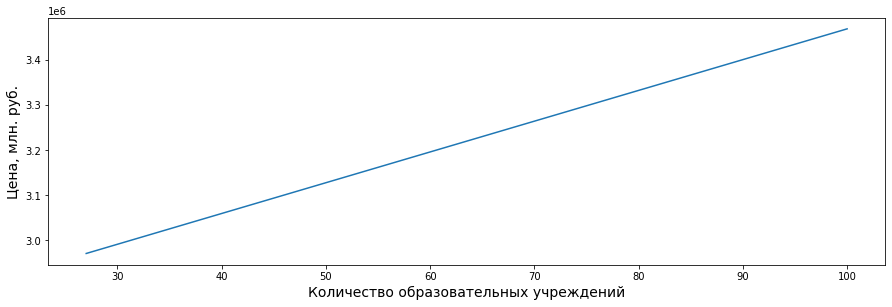

In [252]:
start_value = 27
end_value = 100
values = np.linspace(start_value, end_value, 20)
new_prices = []

model.eval()
with torch.no_grad():
    for value in values:
        data = mean_infro_apartment[0].clone().detach().requires_grad_(False)
        data[-5] = torch.tensor(value, dtype=torch.float32)
        y_pred = model(data.reshape(1, -1))
        new_prices.append(y_pred)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(values, new_prices)
plt.xlabel("Количество образовательных учреждений", size=14)
plt.ylabel("Цена, млн. руб.", size=14)
plt.show()

In [253]:
(max(new_prices) - min(new_prices))/(max(values) - min(values))

tensor([[6812.6919]])

### Еда

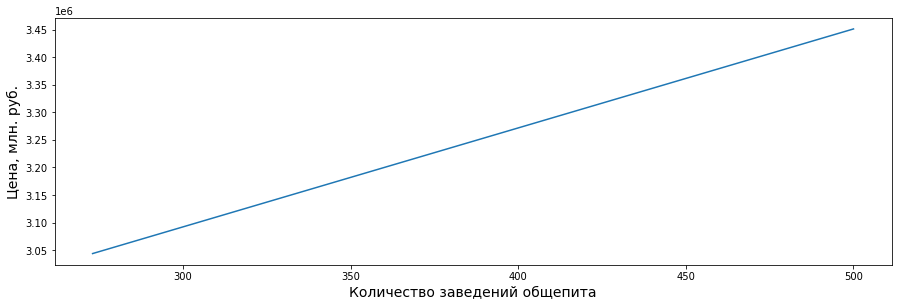

In [254]:
start_value = 273
end_value = 500
values = np.linspace(start_value, end_value, 20)
new_prices = []

model.eval()
with torch.no_grad():
    for value in values:
        data = mean_infro_apartment[0].clone().detach().requires_grad_(False)
        data[-2] = torch.tensor(value, dtype=torch.float32)
        y_pred = model(data.reshape(1, -1))
        new_prices.append(y_pred)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(values, new_prices)
plt.xlabel("Количество заведений общепита", size=14)
plt.ylabel("Цена, млн. руб.", size=14)
plt.show()

In [255]:
(max(new_prices) - min(new_prices))/(max(values) - min(values))

tensor([[1795.8678]])

### Культура

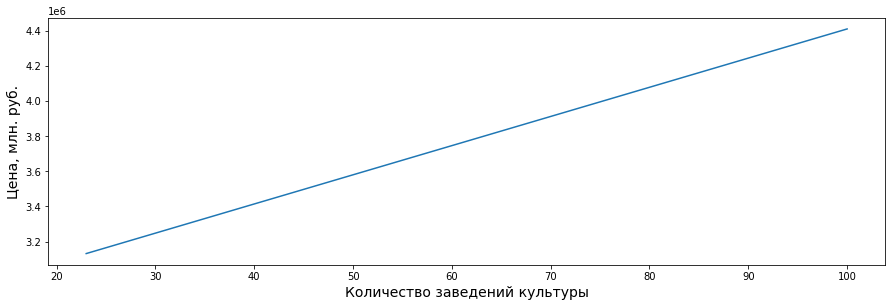

In [256]:
start_value = 23
end_value = 100
values = np.linspace(start_value, end_value, 20)
new_prices = []

model.eval()
with torch.no_grad():
    for value in values:
        data = mean_infro_apartment[0].clone().detach().requires_grad_(False)
        data[-3] = torch.tensor(value, dtype=torch.float32)
        y_pred = model(data.reshape(1, -1))
        new_prices.append(y_pred)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(values, new_prices)
plt.xlabel("Количество заведений культуры", size=14)
plt.ylabel("Цена, млн. руб.", size=14)
plt.show()

In [257]:
(max(new_prices) - min(new_prices))/(max(values) - min(values))

tensor([[16593.8027]])

### Здоровье

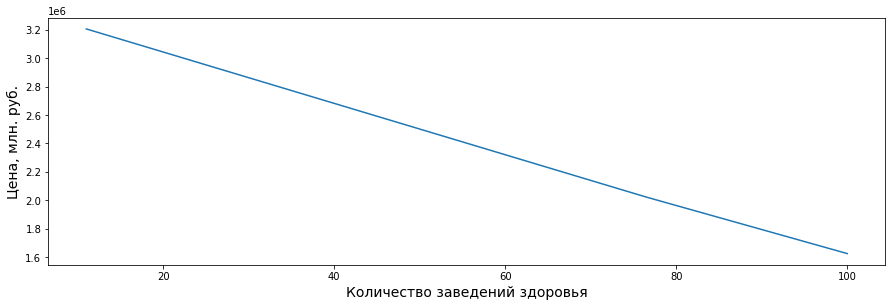

In [258]:
start_value = 11
end_value = 100
values = np.linspace(start_value, end_value, 20)
new_prices = []

model.eval()
with torch.no_grad():
    for value in values:
        data = mean_infro_apartment[0].clone().detach().requires_grad_(False)
        data[-4] = torch.tensor(value, dtype=torch.float32)
        y_pred = model(data.reshape(1, -1))
        new_prices.append(y_pred)

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(values, new_prices)
plt.xlabel("Количество заведений здоровья", size=14)
plt.ylabel("Цена, млн. руб.", size=14)
plt.show()

In [259]:
(max(new_prices) - min(new_prices))/(max(values) - min(values))

tensor([[17732.1230]])

## Влияние удаления квартиры от центра в определенную сторону свет

In [260]:
n = 40 # число точек

In [261]:
apartment1 = torch.tensor([3, 112, 10, 2, 1980, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 58.007385, 56.244263, 62, 42, 11, 386, 937.59], dtype=torch.float32)
apartment2 = torch.tensor([2.0, 61.0, 5.0, 5.0, 1957.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 58.007275, 56.242073, 62.0, 42.0, 11.0, 386.0, 824.05], dtype=torch.float32)
apartment3 = torch.tensor([2.0, 49.1, 10.0, 10.0, 1991.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 58.008354, 56.24494, 63.0, 41.0, 11.0, 384.0, 942.74], dtype=torch.float32)
apartment4 = torch.tensor([1.0, 43.0, 16.0, 3.0, 1998.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 58.00853, 56.233875, 61.0, 42.0, 11.0, 382.0, 337.85], dtype=torch.float32) 
apartment5 = torch.tensor([1.0, 29.0, 17.0, 8.0, 2014.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 58.007603, 56.23196, 61.0, 42.0, 11.0, 386.0, 350.43], dtype=torch.float32)
apartments = [apartment1, apartment2, apartment3, apartment4, apartment5]

In [262]:
perm_esplanade_lat = 58.010455
perm_esplanade_lon = 56.229443

In [263]:
from math import sin, cos, asin, sqrt, pi

def get_dist(llong1, llat1, llong2, llat2):
    
    rad = 6372795
    
    #в радианах
    lat1 = llat1*pi/180.
    lat2 = llat2*pi/180.
    long1 = llong1*pi/180.
    long2 = llong2*pi/180.
    
    #косинусы и синусы широт и разницы долгот
    delta_long = long2 - long1
    delta_lat = lat2 - lat1
    
    #вычисления длины большого круга
    ad = 2 * asin(sqrt(sin(delta_lat/2)**2 + cos(lat1)*cos(lat2)*sin(delta_long/2)**2))
    dist = ad*rad
    
    return dist

In [264]:
district_dict = {
    "Дзержинский район": torch.tensor([1, 0, 0, 0, 0, 0, 0], dtype=torch.float32),
    "Индустриальный район": torch.tensor([0, 1, 0, 0, 0, 0, 0], dtype=torch.float32),
    "Кировский район": torch.tensor([0, 0, 1, 0, 0, 0, 0], dtype=torch.float32),
    "Ленинский район": torch.tensor([0, 0, 0, 1, 0, 0, 0], dtype=torch.float32),
    "Мотовилихинский район": torch.tensor([0, 0, 0, 0, 1, 0, 0], dtype=torch.float32),
    "Орджоникидзевский район": torch.tensor([0, 0, 0, 0, 0, 1, 0], dtype=torch.float32),
    "Свердловский район": torch.tensor([0, 0, 0, 0, 0, 0, 1], dtype=torch.float32),
    "Не район": torch.tensor([0, 0, 0, 0, 0, 0, 0], dtype=torch.float32),
}

In [265]:
with open("../amenities.json", 'r') as f:
    amenities = json.load(f)

In [266]:
def get_districts(lats, lons):
    global district_dict
    districts = []
    geo_coder_url = "https://geotree.ru/coordinates?"
    driver = webdriver.Chrome(ChromeDriverManager().install())
    for lat, lon in zip(lats, lons):
        # Обращаемся к сайту-геокедру
        driver.get(geo_coder_url)
        time.sleep(1)
        # Находим элемент для координат и помещаем туда координаты
        input_lat = driver.find_element_by_id("input_lat")
        input_lat.clear()
        input_lat.send_keys(str(lat))
        input_lon = driver.find_element_by_id("input_lon")
        input_lon.clear()
        input_lon.send_keys(str(lon))
        # Нажимаем на кнопку для поиска
        btn_search = driver.find_element_by_id("button_coordinates")
        btn_search.click()    
        time.sleep(1)
        # Достаем текстовую инфорацию
        text = driver.find_element_by_id("div_components_scroller").text
        not_found = True
        for district in district_dict:
            if district in text:
                districts.append(district_dict[district])
                not_found = False
        if not_found:
            districts.append(districts[-1])
    driver.close()
    return districts

In [267]:
def get_amenities(lats, lons):
    global amenities
    amenities_dict = dict()
    for cat_id, category in enumerate(amenities):
        amenities_dict[category] = [0]*len(lats)
        for idx, (lat, lon) in enumerate(zip(lats, lons)):
            for coordinates in amenities[category]:
                object_lat = coordinates[0]
                object_lon = coordinates[1]
                dist = get_dist(
                    llong1=lon,
                    llat1=lat,
                    llong2=object_lon,
                    llat2=object_lat
                )
                if dist < 5000:
                    amenities_dict[category][idx]+=1
    return amenities_dict

In [268]:
def get_distances(lats, lons):
    global perm_esplanade_lat, perm_esplanade_lon
    distances = []
    for lat, lon in zip(lats, lons):
        dist = get_dist(
            llong1=lon,
            llat1=lat,
            llong2=perm_esplanade_lon,
            llat2=perm_esplanade_lat
        )
        distances.append(dist)
    return distances

In [286]:
def get_prices(apartments, lats, lons, districts, direction_amenities, direction_distances, direction):
    all_prices = []
    edu_list = direction_amenities["edu"]
    health_list = direction_amenities["health"]
    culture_list = direction_amenities["culture"]
    eat_list = direction_amenities["eat"]
    
    model.eval()
    with torch.no_grad():
        for apartment_number, apartment in enumerate(apartments):
            prices = []
            distances = []
            with open(f"apartment{apartment_number}_{direction}.csv", 'a', newline='', encoding="UTF-8") as csv_file:
                writer = csv.writer(csv_file, delimiter=';')
                for idx in range(len(lats)):
                    apartment[23:30] = districts[idx]
                    apartment[30] = lats[idx]
                    apartment[31] = lons[idx]
                    apartment[32] = edu_list[idx]
                    apartment[33] = health_list[idx]
                    apartment[34] = culture_list[idx]
                    apartment[35] = eat_list[idx]
                    apartment[36] = direction_distances[idx]
                    writer.writerow([str(item.item()) for item in apartment])
                    predict_price = model(apartment.reshape(1, -1))
                    prices.append(predict_price)
            
            all_prices.append(prices)
            
    return all_prices

In [280]:
def do_all(lats, lons, direction):
    global apartments
    direction_amenities = get_amenities(lats, lons)
    direction_districts = get_districts(lats, lons)
    direction_distances = get_distances(lats, lons)
    direction_prices = get_prices(apartments, lats, lons, direction_districts, direction_amenities, direction_distances, direction)
    
    plt.figure(figsize=(12, 7))
    plt.xlabel("Удаленность от центра, м", size=14)
    plt.ylabel("Цена, млн. руб.", size=14)

    for idx, apartment in enumerate(apartments):
        area = apartment[1].item()
        plt.plot(direction_distances, direction_prices[idx], label=f"Квартира с площадью {int(area)} $м^2$")

    plt.legend()
    plt.show()

## Удаление на восток

In [287]:
east_lons = np.linspace(perm_esplanade_lon, perm_esplanade_lon+0.2, n) 
east_lats = np.array([perm_esplanade_lat]*n)



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST driver version for 96.0.4664
Driver [C:\Users\Daniil\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


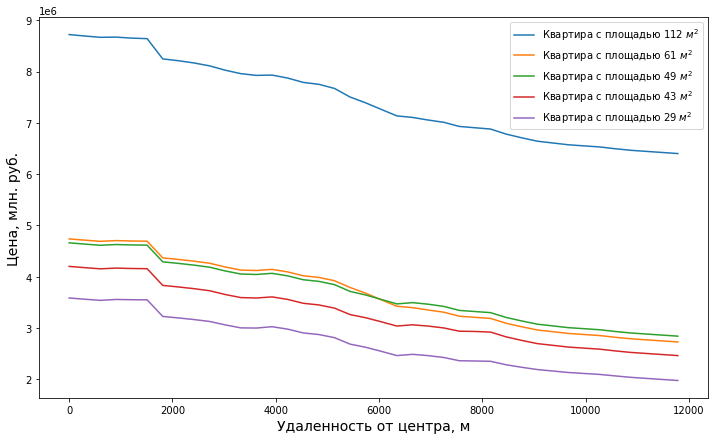

In [288]:
do_all(east_lats, east_lons, 'east')

## Удаление на запад 

In [289]:
west_lons = np.linspace(perm_esplanade_lon, perm_esplanade_lon-0.3, n) 
west_lats = np.array([perm_esplanade_lat]*n)



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST driver version for 96.0.4664
Driver [C:\Users\Daniil\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


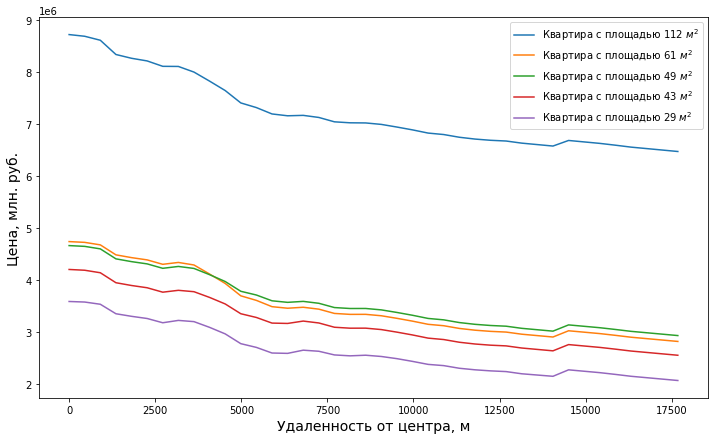

In [290]:
do_all(west_lats, west_lons, 'west')

## Удаленность на север

In [291]:
nord_lons = np.array([perm_esplanade_lon]*n)
nord_lats = np.linspace(perm_esplanade_lat, perm_esplanade_lat+0.15, n) 



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST driver version for 96.0.4664
Driver [C:\Users\Daniil\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


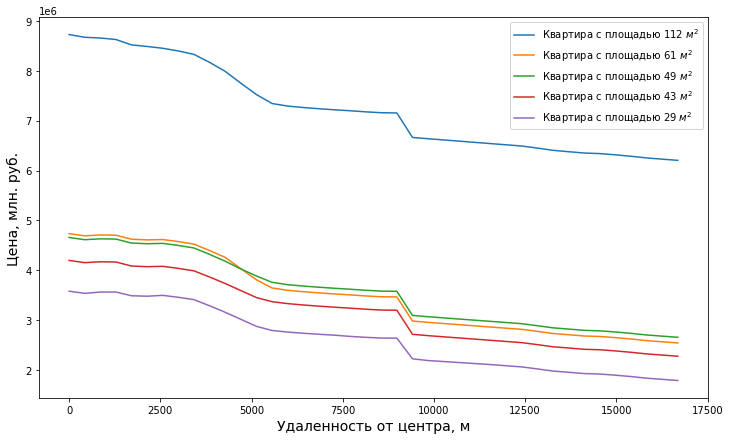

In [292]:
do_all(nord_lats, nord_lons, 'nord')

## Удаленность на юг

In [293]:
south_lons = np.array([perm_esplanade_lon]*n)
south_lats = np.linspace(perm_esplanade_lat, perm_esplanade_lat-0.15, n) 



====== WebDriver manager ======
Current google-chrome version is 96.0.4664
Get LATEST driver version for 96.0.4664
Driver [C:\Users\Daniil\.wdm\drivers\chromedriver\win32\96.0.4664.45\chromedriver.exe] found in cache


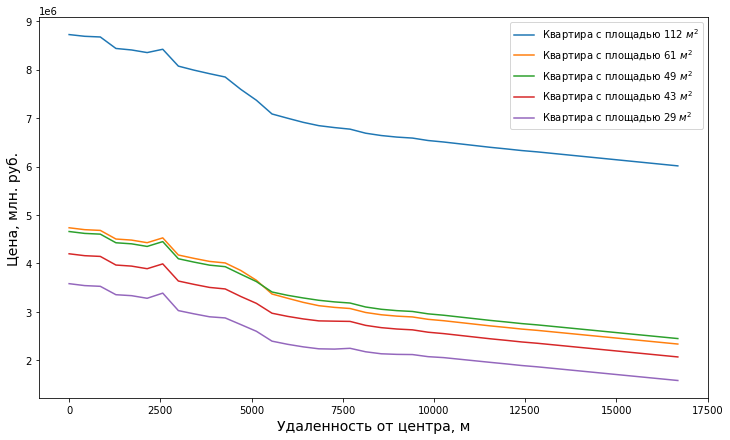

In [294]:
do_all(south_lats, south_lons, 'south')